# Working with Trees

Moving on, we can now lay out a group of tools for wrestling with Trees in the ways in which we want to. As alluded to above, our view is that a tree is a sort of nested panel data structure. This data structure is a matrix, with the last column containing a set of unique identifiers. 

Why do it this way? Well, mainly because of my extensive experience with functions like `panelsetup()` and `panelsubmatrix()` in **Stata\Mata**. Accordingly, I have made a few utility functions that do roughly the same as these: `ps()` and `psm()`, and also some other utility functions like `J()` for creating blank arrays, and `rows()` and `cols()` for getting rows and columns of matrices. As it happens, my programming has drifted away from these as I have gotten more used to Python!


We next need a few functions that replicate the functioning of `panelsubmatrix()` and `panelsetup()` in `Stata` and `Mata`. This will make things a bit easier to work with in terms of our tree. We will shorten the names a little bit, but otherwise work with the ideas as in `Stata`. 


## Resolved Trees 

These utilities form the basis for my first substantive function, `resolvedTree`. What it does is randomly resolves our set of nested panels into a strictly bifurcating set of panels (i.e., each panel subsequently splits into two panels). 

Why have such a function? Why not use a standard tree-puzzling algorithm? Well, for one very big reason: we do not want to randomly puzzle existing trees, but instead build _around_ existing trees. That is, I don't want my algorithms wasting time lumping Greek with Danish and splitting German out. I know German and Danish should be lumped together and Greek should be split out. 

One weakness of this algorithm is that it cannot split a group of 4 into two groups of two, but instead always splits a group of 4 into a group of one and a group of three. This is a practical programming difficulty, not a conceptual one, and one that I have to fix!

Anyways, let's begin by reading in our data from our pickled files, reading in our master data, our data on bifurcations, and our data on overall depths (and importing necessary packages):


In [1]:
import numpy as np
import os
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats.stats import pearsonr
from tqdm import tqdm
from numba import jit
from numpy.random import normal

start_dir = os.getcwd()
python_dir = pathlib.Path(os.getcwd()).parts[:-1] + ('Python',)
os.chdir(pathlib.Path(*python_dir))

import PyInstEvo

os.chdir(start_dir)
os.chdir('..')

%matplotlib inline

In [2]:
Data   = pd.read_pickle(os.getcwd() + '//IEData//MasterData.pkl')
Splits = pd.read_pickle(os.getcwd() + '//IEData//Splits.pkl')
Depths = pd.read_pickle(os.getcwd() + '//IEData//Depths.pkl')

A first convenience is having all of our numerical variables in one little list:

In [3]:
namelist=['TR' + str(x) for x in range(1, 17)]

## Khoisan 

We will now pull out a few specific trees as examples, and see how they look both numerically and when we plot them, and when we resolve them randomly. So, we will start with the Khoisan language tree, as it is of manageable size. 

In [4]:
# Read in the tree 

Khoisan = Data.loc[Data['ruhlen_1'] == "KHOISAN"]

# Print out the matrix representation as it looks in raw form:

print(np.matrix(Khoisan[namelist]).astype(int))

[[ 16  54 155 263 376 431 468 492 507 515 520 527 528 529 535 536]
 [ 16  54 155 263 376 431 468 492 507 515 520 527 528 529 535 536]
 [ 16  55 156 264 377 432 469 493 508 516 521 528 529 530 536 537]
 [ 16  55 156 265 378 433 470 494 509 517 522 529 530 531 537 538]
 [ 16  55 156 265 378 433 470 494 509 517 522 529 530 531 537 538]
 [ 16  55 156 266 379 434 471 495 510 518 523 530 531 532 538 539]
 [ 16  55 156 266 379 434 471 495 510 518 523 530 531 532 538 539]
 [ 16  55 156 266 380 435 472 496 511 519 524 531 532 533 539 540]
 [ 16  55 156 266 380 435 472 496 511 519 524 531 532 533 539 540]
 [ 16  55 157 267 381 436 473 497 512 520 525 532 533 534 540 541]
 [ 16  55 157 267 381 436 473 497 512 520 525 532 533 534 540 541]
 [ 16  55 157 267 381 436 473 497 512 520 525 532 533 534 540 541]
 [ 16  55 158 268 382 437 474 498 513 521 526 533 534 535 541 542]
 [ 16  55 158 269 383 438 475 499 514 522 527 534 535 536 542 543]
 [ 16  55 158 269 383 438 475 499 514 522 527 534 535 536 542 

We see that it looks sort of messy when written like this. A couple of methods I have written make the tree easier to read by translating the group numbers into neater form, and also compressing the matrix by getting rid of duplicate columns. The two relevant functions are `comptree()` and `reindex()`:

In [5]:
KTree=PyInstEvo.comptree(PyInstEvo.reindex(np.matrix(Khoisan[namelist])))
print(KTree)

[[ 0  0  0  0  0  0]
 [ 0  0  0  0  0  1]
 [ 0  1  1  1  1  2]
 [ 0  1  1  2  2  3]
 [ 0  1  1  2  2  4]
 [ 0  1  1  3  3  5]
 [ 0  1  1  3  3  6]
 [ 0  1  1  3  4  7]
 [ 0  1  1  3  4  8]
 [ 0  1  2  4  5  9]
 [ 0  1  2  4  5 10]
 [ 0  1  2  4  5 11]
 [ 0  1  3  5  6 12]
 [ 0  1  3  6  7 13]
 [ 0  1  3  6  7 14]
 [ 0  1  3  6  7 15]
 [ 0  1  3  6  7 16]]


Many of the splits are not bifurcating; in the fourth column, we have the one group of column 3 breaking into 3 new groups all at once. We want to make this into a sequence of splits into 2 groups. Why? Well, in estimation, the number of parameters stays constant if we are always working with bifurcating splits. The function `resolvedtree()` is built to handle this. 

In [6]:
# Resolve the tree randomly. 

print(PyInstEvo.resolvedTree(KTree))

[[ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1]
 [ 0  1  1  1  1  1  1  1  1  1 12]
 [ 0  1  1  1  1  2  2  2  2  2 16]
 [ 0  1  1  1  1  2  2  2  3  3 14]
 [ 0  1  1  1  1  2  2  2  3  4 13]
 [ 0  1  1  1  1  2  2  2  3  4 15]
 [ 0  1  2  2  2  3  3  3  4  5  5]
 [ 0  1  2  2  2  3  3  3  4  5  6]
 [ 0  1  2  2  2  3  4  4  5  6  7]
 [ 0  1  2  2  2  3  4  4  5  6  8]
 [ 0  1  2  2  3  4  5  5  6  7  2]
 [ 0  1  2  2  3  5  6  6  7  8  3]
 [ 0  1  2  2  3  5  6  6  7  8  4]
 [ 0  1  2  3  4  6  7  7  8  9 10]
 [ 0  1  2  3  4  6  7  8  9 10  9]
 [ 0  1  2  3  4  6  7  8  9 10 11]]


### Digression on Indo-Hittite

We can apply the above methods to get a bifurcating example of the Indo-European (Indo-Hittite according to Ruhlen) tree:

In [7]:
# Read in the data

IndoHitt = Data.loc[Data['ruhlen_1'] == 'INDOHITT']

# Compress, clean and then resolve the tree:

IHTree = PyInstEvo.comptree(PyInstEvo.reindex(np.matrix(IndoHitt[namelist])))
IHTree = PyInstEvo.resolvedTree(IHTree)

Because the result is a matrix, we can get a visual picture of the resolution using a simple matrix plot, which I have doctored up in subsequent coding. It gives you some hints as to how the tree is resolved in terms of its panels. Anyways, for now:

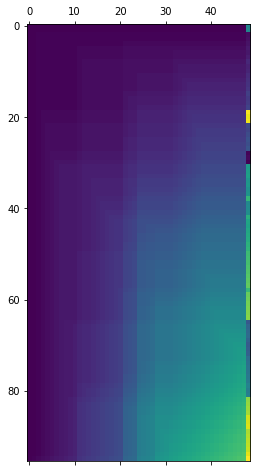

In [8]:
plt.ion()
plt.matshow(IHTree)

## Estimation Routines

Now that we can resolve a tree, we need to begin the process of developing a means of measuring its likelihood, estimating parameters, etc. After the brief digression with the Indo-Hittite tree, we will revisit the Khoisan tree, and for now work with a single randomly-resolved version of this tree:

In [9]:
Tree = PyInstEvo.resolvedTree(KTree)

## Branch lengths

To describe how we can get different branch lengths from our tree, in a way that provides us information on history and time (which, remember, is the ultimate objective!), we deal with branches in the following fashion. 

Imagine that a full tree is of length one, and each branch is a fraction of this length. We therefore use a sort of nested logit approach to get a tree that is of normalized length. 

Take the first branch, with parameter $b_1$, say. That this implies the first branch is a fraction:

\begin{equation}
B_1=\frac{e^{b_1}}{1+e^{b_1}}
\end{equation}

Of the tree. The next parameter creates a second branch based on what is leftover after the first:

\begin{equation}
B_2=\left(1-b_1\right)\frac{e^{b_2}}{1+e^{b_2}}
\end{equation}

and so on. Of course, the last branch is simply what is left over when we get to the last column. Note that we do not need as many parameters as branches with this setup. Typically, there are $n-1$ internal branches of the tree which need a parameter. With this in mind, we can take a tree, and some internal branch parameters, and pass it to a method I've created called `timeFractions()`. This functino can also take information on whether or not a branch has gone moribund, and fill in this information using what I've been calling the `DM` matrix. 

The `DM` matrix has a first column consisting of zeros and ones: zeros occur in the position of moribund languages. The second column contains parameters if the language is moribund. This parameter controls how much the final branch of the tree is shortened relative to the length of the whole tree (right now, normalized at one).

For Khoisan, we can form the matrix as follows.

In [10]:
DM = np.hstack((np.matrix(Khoisan.deadOne).T, PyInstEvo.J(PyInstEvo.rows(Khoisan), 1, 10)))

Here we can see how our `timeFractions` method works:

In [11]:
Test = PyInstEvo.timeFractions(Tree, np.matrix(np.arange(1,30)/100), True, DM )
print(np.nansum(Test, axis=1))
print(Test[0,:])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.57199613 0.22895765        nan        nan        nan        nan
        nan        nan        nan        nan 0.19904622]


The above indicates that all the rows sum to one - the tree is one unit long - and that the first row. We have some additional utilities that give additional information about the tree - `branchcount` counts the total number of branches on a tree, while `branchpos` finds locations in the matrix where branches occur. The convention is that branches are placed in the last entry of the panel and are `np.nan` values elsewhere. 

A further method `BuiltBranchNodes()` takes a tree and its branch positions, along with the origin, non-resolved tree, and then returns information about where the randomly resolved tree points are. 

## Computing the likelihood of a tree 

We are now in a position to compute the likelihood of a tree, which means the likelihood of observing the current word groupings given a tree structure, rate-of-evolution parameters, and branch lengths - all standard elements - to which we will add in prior information handling, and also location and distance information. 

The first part of this is working with the linguistic evolution, which we assume follows the simple Jukes-Cantor method where all transitions between states occur at the same rate. 

It is worth noting the basic steps of this part of computing the likelihood: 

1. Break the parameter vector into its parts: branch parameters, rate parameters, death parameters, overall depth.  
2. Use depth parameters to compute a depth of the tree, along with the prior information on the depth of the tree.
3. Formulate a "death" matrix so that it can be used with your timefractions program. 
4. Get the tree, branch positions, and the States and use the Jukes-Cantor 10-state model to compute the likelihood
5. Use `timeFractions()` with the overall tree depth to compute the timing of all splits. Then, check the splits against the prior information.


**What do we need to do all this?**

1. A function(s) that handles the basic likelihood calculations needed. 
2. A function(s) that can compute split times of any two societies given the tree. 
3. Location and distance functions. 

The fundamental idea is quite simple. Suppose we observe two branches deriving from a common source. We observe that the first branch is currently in state $s_i$, while the second is currently in $s_j$. Our tree tells us that some time $t_b$ ago, these two branches had a common ancestry, meaning they were in the same state at one point. If we have some theory of transition probabilities, we can compute the probability that the groups are in the current state, given some initial state, as the product:

\begin{equation}
p(s_i,t_b|s_0)p(s_j,t_b|s_0)
\end{equation}

Of course, we usually don't know the initial state, so we would just sum over the possibilities to get:

\begin{equation}
\sum p(s_i,t_b|s_0)p(s_j,t_b|s_k)\pi_k
\end{equation}

Given a set of data on tips, and parameters for $t_b$, some transition model, and some initial probabilities, we now can compute a likelihood for the parameters $t_b$.  The Felsenstein pruning algorithm applies this logic recursively. To do this, we need some means of thinking about transition probabilities. The simplest possible model, I think, is the Jukes-Cantor model, which posits that we bounce around between states randomly at a constant rate. 

## Jukes-Cantor


The way the typical Jukes-Cantor model works is one has a set of discrete states, and a constant rate of transition between these states. Typically, the transition matrix generator is taken as something like: 

\begin{equation}
G(r)=\left[\begin{array}{cc} 
-9r & r & r & \dots & r \\
r & -9r & r & \dots & r \\
r &    & \ddots &  & \vdots \\
r & \dots   &  & & -9r      
\end{array}\right]
\end{equation}


The matrix $G(r)$ gives the instantaneous probability of transitioning from state $i$ to state $j$ over the time t, when there are 10 total states (i.e., 10 Dogopolsky classes). Probabilities over times can be obtained by multiplying the above matrix by $t$ and computing the matrix exponential, which in this case has a closed form:

\begin{equation}
Q(rt)=e^{G(r)t}=\left[\begin{array}{cc} 
\frac{1}{10}+\frac{9}{10}e^{-9rt} & \frac{1}{10}-\frac{1}{10}e^{-9rt} & \frac{1}{10}-\frac{1}{10}e^{-9rt} & \dots & \frac{1}{10}-\frac{1}{10}e^{-9rt} \\
\frac{1}{10}-\frac{1}{10}e^{-9rt} & \frac{1}{10}+\frac{9}{10}e^{-9rt} & \frac{1}{10}-\frac{1}{10}e^{-9rt} & \dots & \frac{1}{10}-\frac{1}{10}e^{-9rt} \\
\frac{1}{10}-\frac{1}{10}e^{-9rt} &    & \ddots &  & \vdots \\
\frac{1}{10}-\frac{1}{10}e^{-9rt} & \dots   &  & & \frac{1}{10}+\frac{9}{10}e^{-9rt}      
\end{array}\right]
\end{equation}



Suppose we have a set of initial probabilities $\pi_1,\dots,\pi_{10}$. We then can find the probability of being in state $j$ given a start in stage $i$ after a timespan $t$ through simple matrix-vector multiplication:

$
P(t)=Q(rt)'\Pi
$

The vector $P(t)$ then holds the probability that we are in each state after a time period $t$, given $r$ transition rate. A couple of notes:

1. While generically one wants to use the transpose of Q, the JC transition matrix is symmetric so it doesn't matter. 
2. Since the rate parameter $r$ always appears multiplied by 9, we can just use $\tilde{r}=9r$ in estimation. 
3. We have a different matrix for each word, so it behooves us to think of a way to do everything at once.  

So, one component of the likelihood is computed using this basic algorithm, which works backwards through the tree for a variety of reasons. When we discuss our tree classes, we will get in to this a bit more.

# Split likelihoods

Given a tree and some dates, we can see how well things match up with prior splits. This serves to calibrate the rates of transition along the tree. This data looks as follows, and tells us the years ago that two linguistic groups split apart. We also affix this with a standard deviation. So, if our model suggests a split date of $d$, we then add to the tree a likelihood of 

$
SplitLike=\phi \left(\frac{y-d}{sd}\right)
$:

where $\phi$ is the standard normal distribution. Hence, if our branches, splits, and parameters better align with the prior split dates, the likelihood of the tree is higher. A sample:

In [12]:
Splits[0:5]

,phylum,language1,language2,years,sdyears
0,AfroAsia,ETHIOPIC,GEEZ,2450,10
1,AfroAsia,ETHIOPIC,TIGRE,2450,10
2,AfroAsia,ETHIOPIC,ARGOBRA,2450,10
3,AfroAsia,MALTESE,TUNISIAN_ARABIC_MAGHRIB,910,10
4,AfroAsia,EASTERN_OROMO,MECHA_OROMO,2500,10


As a practical matter, we do this from values spit out by our tree as follows. If the total depth of the tree (in millenia) is $T_H$, and $f$ is the fraction of time the groups have been together, we have $T(1-f)$ as the time that they have been apart, which is also the split time. We use methods called `FractionCommon()` and `SplitLikelihood()` to compute the likelihood.

# A jump migration model

Another means of assessing a tree is how likely the migration patterns predicted by the model actually are, given what is known and some sort of theoretical model. I have developed a model that conserves independent migratory events, in a manner of speaking, which at once suggests the most likely spatial point of origin of a tree while at the same time giving a measure of likelihood. This is discussed in a subsequent workbook. One part of this is computing pairwise distances between groups.

## Distances and computation

As location and distance will play a role in the next component of the likelihood of a tree, we develop a method that computes pairwise distances between a bunch of groups, given a list of latitudes and longitudes, `gcircledist()`. This has been a brief preview as to how we are going to settle on which sorts of trees, locations, branching times, are most likely. In a subsequent workbook which applies the contents of `PyIETools` and `PyIEClasses` - a module that develops a phylogenetic tree and associated data into a class - I will show how all these work. 

Additionally, I would like to produce full documentation for all functions and classes. 